## simple debug setup

In [1]:
import os, osr, glob
import xarray as xr
import rioxarray
from rioxarray.merge import merge_datasets, merge_arrays
import numpy as np
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#
import seaborn as sns
#
from equi7grid.equi7grid import Equi7Grid
#%matplotlib widget
#%matplotlib inline

In [2]:
# set the tile, row, col, and polarisation  to read:
myTile = 'E078N066T3'
myRow = 9
myCol = 5
myPol = 'VH'

In [3]:
# set the folter wih the output files:
data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E078N066T3_OrbitWise'
fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_1000_' + 'D039_'+ myPol + '.nc'

In [4]:
# set for the small chanks:
#data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  'E078N066T3_smallChanks'
#fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + 'D039_'+ myPol + '.nc'

Reading in case of single row and column:

In [5]:
my_out = rioxarray.open_rasterio(os.path.join(data_folder, fileName))

Read forest age and LULC data:

In [6]:
fileName2 = r'myforAgeLCLU_E078N066T3_chunk1000_9_5.tif'
forAgeLULC = rioxarray.open_rasterio(fileName2, band_as_variable=True)
# convert to dataset:
forAgeLULC_ds = forAgeLULC.to_dataset('band').rename({1: 'forAge2017', 2: 'lulc2018', 3: 'lulc2019', 4: 'forAge2020', 5: 'ECO_ID'})

Correct coordinates (temporary soluton!!!)

In [7]:
forAgeLULC_ds['y'] = forAgeLULC_ds.y + 10
forAgeLULC_ds['x'] = forAgeLULC_ds.x - 10

In [8]:
my_out

<xarray.Dataset>
Dimensions:           (y: 1000, x: 1000, band: 1)
Coordinates:
  * y                 (y) float64 6.72e+06 6.72e+06 6.72e+06 ... 6.7e+06 6.7e+06
  * x                 (x) float64 7.9e+06 7.9e+06 7.9e+06 ... 7.92e+06 7.92e+06
  * band              (band) int64 1
    spatial_ref       int64 0
Data variables: (12/73)
    exception_label   (band, y, x) float64 ...
    max_mag           (band, y, x) float64 ...
    max_mag_date      (band, y, x) float64 ...
    t_pre             (band, y, x) float64 ...
    t_post            (band, y, x) float64 ...
    t_total           (band, y, x) float64 ...
    ...                ...
    MAD_2017          (band, y, x) float64 ...
    MAD_2018          (band, y, x) float64 ...
    MAD_2019          (band, y, x) float64 ...
    MAD_2020          (band, y, x) float64 ...
    seg_id            (band, y, x) float64 ...
    seg_size          (band, y, x) float64 ...

## Analyse annual statistics

In [9]:
# Add the combined annual statistics:
my_out['qDiff_2017'] = my_out['q90_2017'] - my_out['q10_2017']
my_out['dRange_2017'] = my_out['max_2017'] - my_out['min_2017']
my_out['iqRange_2017'] = my_out['q75_2017'] - my_out['q25_2017']

In [10]:
# set the relevant statistics:
myStatnames = ['mean_2017', 'median_2017', 'std_2017', 'MAD_2017', 'dRange_2017', 'qDiff_2017', 'iqRange_2017']
# mearge the arrays into new dataset:
my_ds = xr.merge([my_out[myStatnames], forAgeLULC_ds['forAge2017']])

In [11]:
# convert to pandas data frame
my_df = my_ds.where((my_ds['forAge2017'] > 0) & (my_ds['forAge2017'] < 50)).to_dataframe()
# drop unneccery data:
my_df.drop(columns='spatial_ref', inplace=True)
my_df.dropna(subset=['forAge2017'], inplace=True)

In [12]:
# group by year:
df_med = my_df.groupby(by='forAge2017').mean()

## Plotting

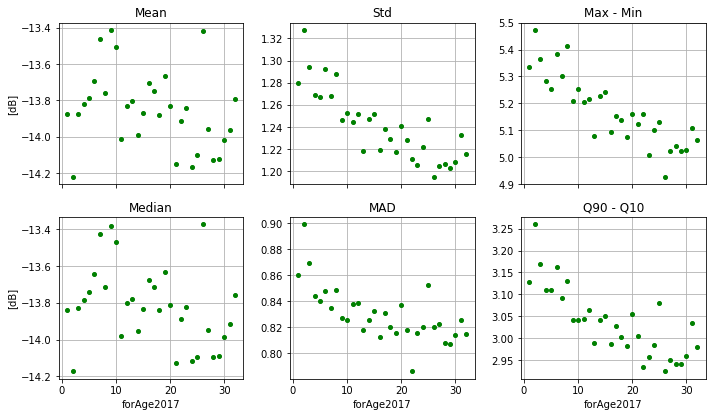

In [13]:
#%matplotlib widget
#%matplotlib inline
#
fig, axs = plt.subplots(2, 3, figsize=(10, 5.9), sharex=True)
# add plots
df_med.mean_2017.plot(style='o', grid=True, ax=axs[0, 0], title='Mean', **{'markersize': 4, 'color':'green'})
df_med.std_2017.plot(style='o', grid=True, ax=axs[0, 1], title='Std', **{'markersize': 4, 'color':'green'})
df_med.dRange_2017.plot(style='o', grid=True, ax=axs[0, 2], title='Max - Min', **{'markersize': 4, 'color':'green'})
#
df_med.median_2017.plot(style='o', grid=True, ax=axs[1, 0], title='Median', **{'markersize': 4, 'color':'green'})
df_med.MAD_2017.plot(style='o', grid=True, ax=axs[1, 1], title='MAD', **{'markersize': 4, 'color':'green'})
df_med.qDiff_2017.plot(style='o', grid=True, ax=axs[1, 2], title='Q90 - Q10', **{'markersize': 4, 'color':'green'})
#
axs[0, 0].set_ylabel('[dB]')
axs[0, 1].set_ylabel('')
axs[0, 2].set_ylabel('')
#
axs[1, 0].set_ylabel('[dB]')
axs[1, 1].set_ylabel('')
axs[1, 2].set_ylabel('')
#
fig.tight_layout()


Calculate the number of forest age pixels

In [100]:
# group by year:
df_count = my_df.groupby(by='forAge2017').mean_2017.count()

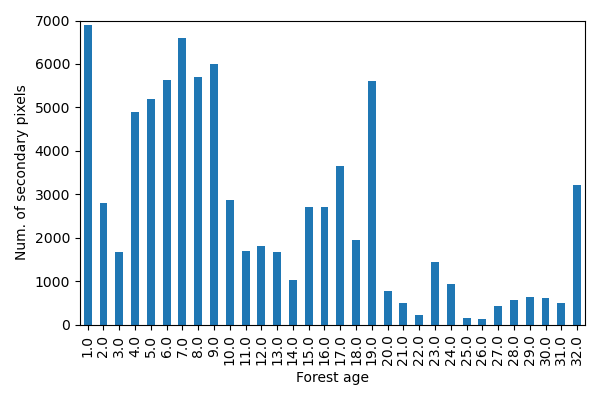

In [104]:
%matplotlib widget
#%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
df_count.plot.bar(ax=axs)#
axs.set_xlabel('Forest age')
axs.set_ylabel('Num. of secondary pixels')
axs.set_ylim([0, 7000])
fig.tight_layout()

Plotting

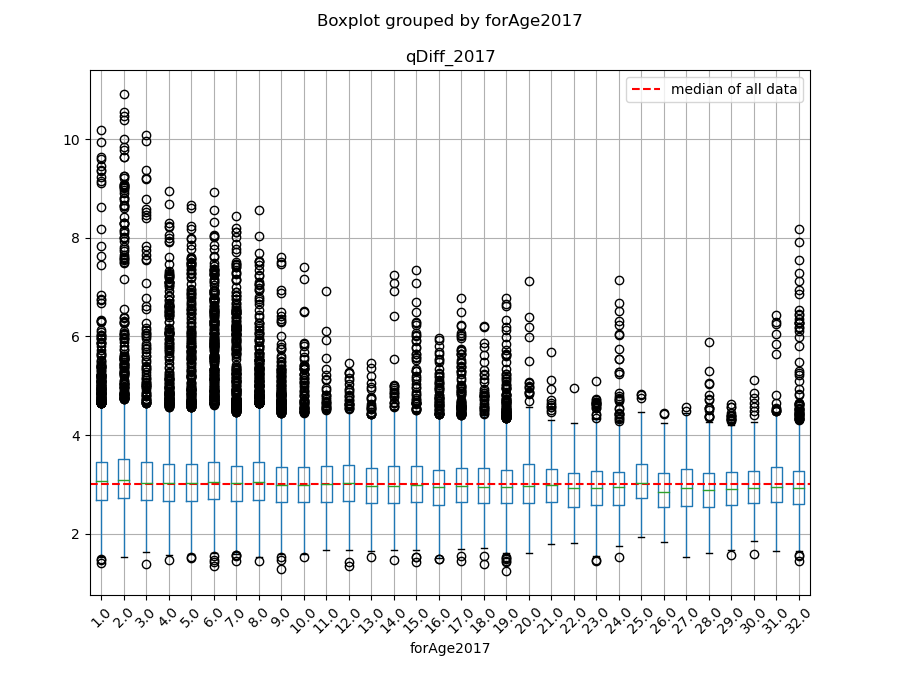

In [25]:
%matplotlib widget
#%matplotlib inline
my_df.boxplot('qDiff_2017', by='forAge2017', grid=True, rot=45, figsize=(9, 7))
# add the parameter value (all data) as horizontal line:
plt.axhline(y=my_df['qDiff_2017'].median(), color='r', linestyle='--', label='median of all data')
plt.legend(loc='upper right')

## Analyse the recovery time:

Select ts with disturbance-recovery pattern 

In [42]:
# mearge the arrays into new dataset:
mearged_ds = xr.merge([my_out, forAgeLULC_ds])

In [43]:
#%matplotlib widget
#%matplotlib inline
#
# eception label selection:
# 0 - tipical disturbance (including aklso no recovery!!! see TS_end_flag and TS_end_flag_long)
# 1 - no data
# 2 - no disturbance
# 3 - atipical disturbance (mean TS is above the refernce bounds)
# ------------
# TS_end_flag:
# -1 - below the reference
#  0 - in reference bounds
#  1 - above the reference
# -------------------------------------------------------------------------------
recov_da = mearged_ds.where((mearged_ds.exception_label==0) & (mearged_ds.max_mag>0) & (mearged_ds.TS_end_flag>=0))

In [56]:
recov_da['t_seg'] = np.fabs(recov_da['t_pre']) + np.fabs(recov_da['t_post'])

<AxesSubplot:xlabel='t_total', ylabel='max_mag'>

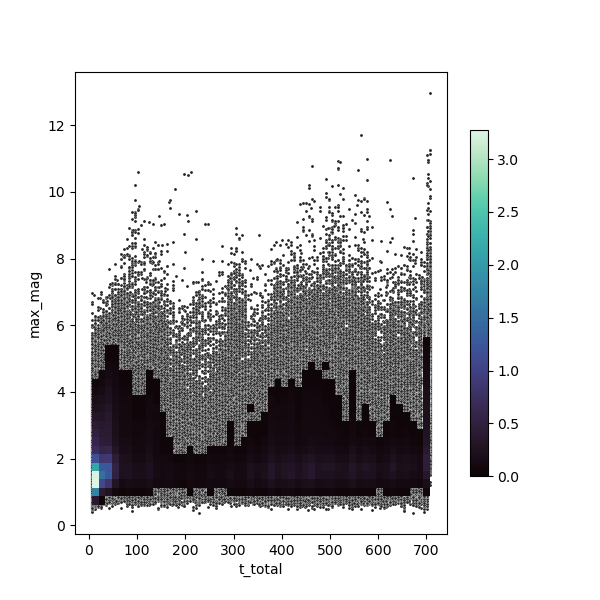

In [71]:
bb = recov_da[['t_seg', 'max_mag']]
#
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=bb.to_dataframe(), x="t_seg", y="max_mag", s=5, color=".15")
sns.histplot(data=bb.to_dataframe(), x="t_seg", y="max_mag", bins=50, 
             pthresh=0.1, cmap="mako", cbar=True, cbar_kws=dict(shrink=.75), stat='percent', 
             log_scale=[False, False])
#sns.kdeplot(data=bb.to_dataframe(), x="t_seg", y="max_mag", levels=5, color="w", linewidths=1)

3